# BAYa class Assignment 2022

In this assignment, your task will be to implement and analyze inference in the Bayesian Laten Dirichlet Alocation (LDA) model as
described in the corresponding [slides from BAYa class](http://www.fit.vutbr.cz/study/courses/BAYa/public/prednasky/4.5-LatentDirichletAllocation.pdf). You will accomplish this task by completing this Jupyter Notebook, which already comes with a code generating the training data and some plotting functions for presenting the results. If you do not have any experience with Jupyter Notebook, the easiest way to start is to install Anaconda3, run Jupyter Notebook and open this notebook downloaded from [BAYa_Assignment2022.ipynb](http://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks/BAYa_Assignment2022.ipynb). You can also find some ispiration and pieces of code to reuse (e.g. KL divegence for Dirichlet distribution) in the other [Jupyter Notebooks provided for this class](http://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks).

The Notebook is organized as follows:
1. First comes a cell with a code of functions that will be used for presenting the results and the learned models. Specifically, it contais code for plotting points into 2-simplex, plotting Dirichlet distribution and plotting topic specific distributions. You can skip this cell first as the use of the functions will be demostrated later.
2. Next comes a code which "handcrafts" some parameters of the LDA model and implements the generative process assumed by the LDA model. The code generates some artificial training data that you will use for LDA model training. Please carefully read this code and the comments around.
3. At the end of this notebook, there are cells with instructions to fill in your implementation of the LDA model training using Gibbs Sampling (GS) and Variationa Bayes (VB) inference. There are also fileds with other tasks to accomplish and questions to answer.



The following cell contains code with the definition of the training data and the contrastive system training. You should not edit this part! The code does the following:

In [2]:
# Run this code! But there is no need to pay much attention to this cell at the first pass through the notebook

% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import scipy.stats as sps
from scipy import sparse

# Pre-calculate some global data used by functions plot_simplex, plot_dirichlet and plot_points_in_simplex
_corners = np.array([[0, 0], [1, 0], [0.5, 0.75 ** 0.5]])
_invT = np.linalg.inv(_corners[:2] - _corners[2])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
_refiner = tri.UniformTriRefiner(_triangle)
_trimesh = _refiner.refine_triangulation(subdiv=7)
# Now convert _trimesh 2D cartesian coordinates to 3D barycentric coordinates (i.e. 3D point on the 2D simplex)
# as described in https://en.wikipedia.org/wiki/Barycentric_coordinate_system#Edge_approach
# We calculate only the first 2 barycentric coordinates as sps.dirichlet.pdf is happy without the last one (l3 = 1-l1+l2)
_tol = 1.e-8
_l1l2 = (np.c_[_trimesh.x, _trimesh.y] - _corners[2]) @ _invT
_l1l2 = np.clip(_l1l2, 2 * _tol,
                1.0 - _tol) - _tol  # to make sure that none of the probabilities is exactly zero or one


def plot_simplex(class_labels=[""] * 3):
    '''Plot "axis" for 2-simplex. It simply plots a triangle into which we will be ploting points
       representing Categorical distributions (for 3 categories/topics) or a Dirichlet distribution.
    Arguments:
       class_labels: list of 3 strings that are used as labels (i.e. category/topic names) for the
       simplex (triangle) corners
    '''
    plt.triplot(_triangle, linewidth=1)
    #plt.xlim(0, 1)
    #plt.ylim(0, 0.75**0.5)
    plt.axis('equal')
    plt.axis('off')
    plt.text(0, 0, class_labels[0], horizontalalignment='left', verticalalignment='top')
    plt.text(1, 0, class_labels[1], horizontalalignment='right', verticalalignment='top')
    plt.text(0.5, 0.75 ** 0.5, class_labels[2], horizontalalignment='center', verticalalignment='bottom')


def plot_dirichlet(alpha, nlevels=128, **kwargs):
    '''Plot Dirichlet pdf in an equilateral triangle (2-simplex).
    Arguments:
        alpha: Dirichlet distribution parameters.
        nlevels (int): Number of contours (shades) to draw.
        kwargs: Keyword args passed on to `plt.tricontourf`.
    '''
    plt.tricontourf(_trimesh, sps.dirichlet.pdf(_l1l2.T, alpha), nlevels, cmap='gray_r', **kwargs)


def plot_points_in_simplex(X, **kwargs):
    '''Plots a set of points in the 2-simplex. Each point can represent
       a categorical distribution with 3 categories/topics.
    Arguments:
        X: A Nx3 array in barycentric coordinates of points to plot.
        kwargs: Keyword args passed on to `plt.plot`.
    '''
    plt.plot(*(X @ _corners).T, **kwargs)


def plot_topic_distributions(Phi, vocabulary, top_V=10):
    '''Plot words and their probabilities for each topic.
    Arguments:
        Phi: A KxD matrix where rows are topic specific distributions
        vocabulary: List of strings that are words corresponding to columns of Phi
        top_V: Only top_V most likely words and their probabilities are shown.
    '''
    plt.figure(figsize=(20, 4))
    for k, topic_dist in enumerate(Phi):
        plt.subplot(1, len(Phi), k + 1)
        sort_ixs = np.argsort(topic_dist)[::-1]
        top_V_words = [vocabulary[i] for i in sort_ixs[:top_V]]
        plt.barh(np.arange(len(top_V_words) / 2, 0, -0.5), topic_dist[sort_ixs[:top_V]], height=0.4)
        plt.yticks(np.arange(len(top_V_words) / 2, 0, -0.5), top_V_words, fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.title("Topic %2d" % (k + 1,))
        plt.xlabel("Probability")

## LDA generative process
The generative process assumed by the Bayesian Laten Dirichlet Alocation model is

\begin{align}
{\boldsymbol\varphi}_k &\sim \operatorname{Dir}(\boldsymbol{\beta}_0), && \text{for } k=1, \dots, K\\
{\boldsymbol\theta}_d &\sim \operatorname{Dir}(\boldsymbol{\alpha}_0), && \text{for } d=1, \dots, D\\
z_{dn} &\sim \operatorname{Cat}(\boldsymbol\theta_d),  &&\text{for } d=1, \dots, D,\quad n=1, \dots, N_d\\
w_{dn} &\sim \operatorname{Cat}(\boldsymbol\varphi_{z_{dt}}),   &&\text{for } d=1, \dots, D,\quad   n=1, \dots, N_d,\\
\end{align}
where ${\boldsymbol\varphi}_k$ are topic specific word distributions, ${\boldsymbol\theta}_d$ are document specific topic distributions (topic mixture weights), $z_{dn}=k$ denotes that the $n^{th}$ word in document $d$ comes from topic $k$, and $w_{dn}=v$ denotes that the $n^{th}$ word in document $d$ is $v$. However, our training data will not be represented in terms of $w_{dn}$. It will be compactly represented by a $D\times V$ word count matrix $\boldsymbol{M}$ with elements $M_{dv}$ counting how many times document $d$ contains word $v$.

Let the $V\times K$ matrix of topic specific word distributions be
$$\boldsymbol\Phi = [{\boldsymbol\varphi}_1, {\boldsymbol\varphi}_2, \dots, {\boldsymbol\varphi}_K],$$
and let the $K\times D$ matrix of document specific topic distributions (topic mixture weights) be
$$\boldsymbol\Theta = [{\boldsymbol\theta}_1, {\boldsymbol\theta}_2, \dots, {\boldsymbol\theta}_D]$$

Mathematicians like to use column vectors and form matrices by stacking the vectors into the columns of the matrices. In python, it is more convenient to work with row vectors and stack them into matrix rows. Therefore, everything in the code will be trasposed as compared to the equations. E.g., the $V\times K$ matrix $\boldsymbol\Phi$ will be represented by numpy.array named **Phi** with shape (K, V). Similarly, $\boldsymbol\Theta$ will be represented by numpy.array named **Theta** with shape (D,K).

## Handcrafting the LDA model
### Handcrafting  $\boldsymbol\Phi$
First, we handcraft the matrix $\boldsymbol\Phi$ containing topic specific word distributions. We hadcraft $\boldsymbol\Phi$ directly rather that sampling it from the Dirichlet prior as the generative process for Bayesian LDA would suggest. The Dirichlet prior will be still used later for LDA model training. We store the handcrafted matrix $\boldsymbol\Phi$ to the variable **Phi_gt**, where **_gt**, stays for "ground truth". We will generate our training using this matrix, and we hope to learn this matrix back (or some close to it) during the LDA model training. We consider only a toy example with $K=3$ topics ("sports", "computers", "food") and a vocabulary of only $V=6$ distinct words (stored in the variable **vocabulary**).

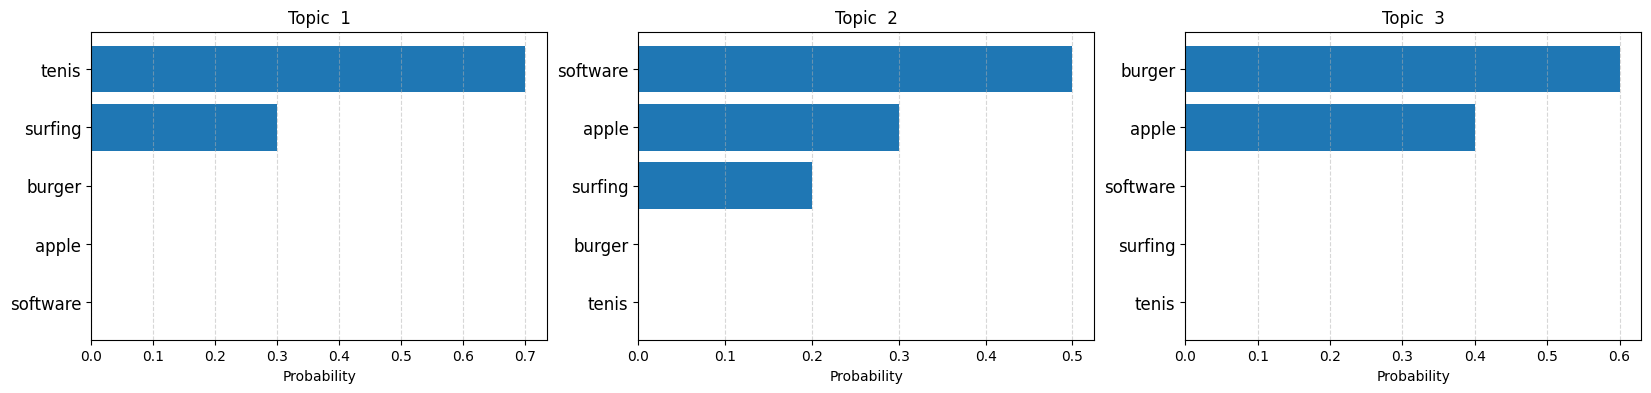

In [3]:
vocabulary = ['tenis', 'surfing', 'software', 'apple', 'burger']  # TOPIC:
Phi_gt = np.array([[0.7, 0.3, 0.0, 0.0, 0.0],  # sports
                   [0.0, 0.2, 0.5, 0.3, 0.0],  # computers
                   [0.0, 0.0, 0.0, 0.4, 0.6]])  # food
plot_topic_distributions(Phi_gt, vocabulary)

Note that the word "surfing" can likely occur for both topics "sports" and "computers". Similarly, word "apple" can likely occur for both topics "food" and "computers". Note also that we have given names to the topics in our example, but in real data, the topics in the training data and their number (the parameter $K$) are unknown.

We used the function **plot_topic_distributions** to plot the word distributions for each topic. Each plot shows probabilities of words for one topic sorted by the the word probability. The function shows (at most) only the top_V=10 most likely words, which will be usefull when figuring out what the topics correspond to for real data.

### Handcrafting  $\boldsymbol\Theta$
Now, we will handcraft the matrix $\boldsymbol\Theta$ with topic distributions (or topic mixture weights) ${\boldsymbol\theta}_d$ one for each training document $d$. We will pretend that there are 4 tematically focused document collections in our training data with documents about:
* sports
* computers
* food
* food for sportsmen

Each collection will contain **documents_per_collection**=20 training documents. In the following code, for each document $d$, the topic mixture weights ${\boldsymbol\theta}_d$ are sampled from a collection specific Dirichlet distribution (see the grayscale plots produced by the next cell). The parameters of these 4  Dirichlet distributions are given in the rows of the matrix **alpha4collections** in the code below.

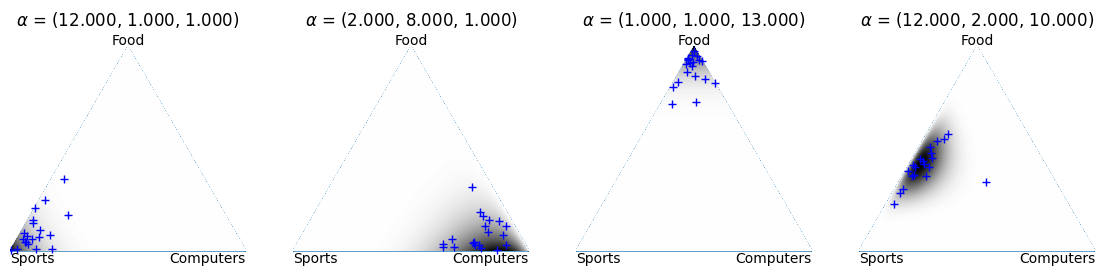

In [4]:
                            # sports computers food  # Collection of documents about ...
alpha4collections = np.array([[12, 1, 1],  # sports
                              [2, 8, 1],  # computers
                              [1, 1, 13],  # food
                              [12, 2, 10]])  # food for sportsmen
documents_per_collection = 20
Theta_gt = []
plt.figure(figsize=(14, 3))

# For each collection
for i, a in enumerate(alpha4collections):
    plt.subplot(1, len(alpha4collections), i + 1)
    plt.title(r'$\alpha$ = (%.3f, %.3f, %.3f)' % tuple(a))

    # Plot 2-simplex (a triangle) and add topic labels to the corners of the triangle where those topics have probability 1
    plot_simplex(['Sports', 'Computers', 'Food'])

    # Plot collection specific Dirichlet distribution (in grayscale)
    plot_dirichlet(a)

    # Sample topic mixture weights for all documents in one collection
    thetas4collection = sps.dirichlet.rvs(a, documents_per_collection)

    # Plot topic mixture weights as points in the simplex
    plot_points_in_simplex(thetas4collection, c='b', ls='none', marker='+')
    Theta_gt.append(thetas4collection)

# Concatenate all topic weights from all collections into single matrix
Theta_gt = np.concatenate(Theta_gt)

# For each document, remember the label saying which colection it comes from
collection_label = np.repeat(range(len(alpha4collections)), documents_per_collection)


Each plot (triangle) produced by the code above is a 2-simplex corresponding to one of the collections. It shows its corresponding Dirichlet distribution (in grayscale). Each blue cross is a sample from that Dirichlet distribution representing the topic mixture weights ${\boldsymbol\theta}_d$ for one training document. We can see that, in the first collection (documents about sports), all documents have high weights for the topic "sports" and low weights for the other two topics. In contrast, in the last collection (documents about food for sportsmen), all documents have comparable high weights for the topics "sports" and "food" and low weight for the topic "computers".

At the end of the code in the cell above, we concatenate all the document specific mixture weights ${\boldsymbol\theta}_d$ from all the collections into single matrix **Theta_gt** representing the "ground truth" matrix $\boldsymbol\Theta$. Just like in the case of **Phi_gt**, our task will be to recover **Theta_gt** (or something close to it) during the LDA model training.

We also remember the collection label for each training document in the variable **collection_label**. One of your tasks will be to cluster the documents into collections and **collection_label** will be usefull to see whether you manage to recover the original "ground truth" document collections.

### Plotting all handcrafted ${\boldsymbol\theta}_d$ into a single simplex

In the code below, we plot all the mixture weights ${\boldsymbol\theta}_d$ for all training documents into sigle simplex. We also stop pretending that we know the the topic names. Instead, we use the most likely word from each topic specific distribution as the representative topic labels (i.e. the labels in the corners of the simplex). We also indicate the "ground truth" collection label by the color and marker of each point. This is how you will later plot the learned mixture weights ${\boldsymbol\theta}_d$ and how you will be able to indicate your clustering of the documents.


In [5]:
Theta_gt


array([[9.07682145e-01, 4.75440477e-02, 4.47738072e-02],
       [7.24045918e-01, 2.38767481e-02, 2.52077334e-01],
       [9.92763012e-01, 1.63480831e-03, 5.60217927e-03],
       [8.77523501e-01, 6.27647081e-02, 5.97117904e-02],
       [8.20204766e-01, 7.48484412e-02, 1.04946793e-01],
       [8.42035549e-01, 9.06954174e-02, 6.72690336e-02],
       [8.89741291e-01, 3.52374236e-02, 7.50212854e-02],
       [7.88211542e-01, 1.91886079e-03, 2.09869597e-01],
       [8.16061013e-01, 1.74057239e-01, 9.88174773e-03],
       [8.36254712e-01, 2.79336772e-02, 1.35811610e-01],
       [9.64462054e-01, 2.36237782e-02, 1.19141679e-02],
       [6.67825179e-01, 1.55805837e-01, 1.76368984e-01],
       [7.90340932e-01, 1.30021782e-01, 7.96372861e-02],
       [9.16864158e-01, 2.45970118e-02, 5.85388302e-02],
       [8.85060902e-01, 1.03352961e-01, 1.15861364e-02],
       [9.15349432e-01, 3.88494490e-02, 4.58011193e-02],
       [8.23532940e-01, 2.27471939e-02, 1.53719866e-01],
       [5.96242432e-01, 5.20169

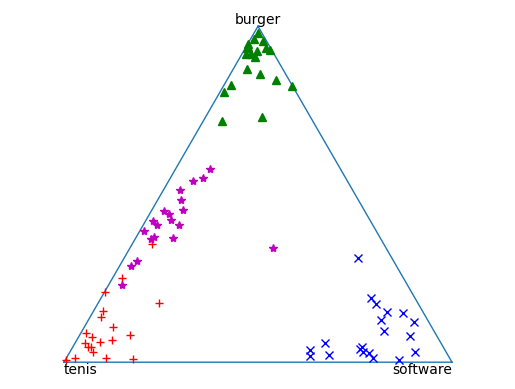

In [6]:
plot_simplex([vocabulary[np.argmax(p)] for p in Phi_gt])
markers = ['+', 'x', '^', '*']
colors = ['r', 'b', 'g', 'm']
for i, t in enumerate(Theta_gt):
    plot_points_in_simplex(t, c=colors[collection_label[i]], ls='none', marker=markers[collection_label[i]])

### Sampling training data
Once we have the matrices $\boldsymbol\Phi$ and $\boldsymbol\Theta$, we can obtain the word distribution specific to document $d$ as $\boldsymbol\Phi {\boldsymbol\theta}_d$. Or more efficiently, we can obtain matrix of the distribution for all the documents as $\boldsymbol\Phi\boldsymbol\Theta$. Finaly, for document $d$, we can sample the vector of word counts (i.e a row of the word count matrix $\boldsymbol{M}$) from the distribution $\operatorname{Multinomial(\boldsymbol\Phi{\boldsymbol\theta}_d,N_d)}$. For simplicity, in the code below, we assume that each training document contains the same number of $N_d=N=100$ words. The training word count matrix is stored in variable **M**.

In [7]:
Phi_gt


array([[0.7, 0.3, 0. , 0. , 0. ],
       [0. , 0.2, 0.5, 0.3, 0. ],
       [0. , 0. , 0. , 0.4, 0.6]])

In [8]:
Theta_gt


array([[9.07682145e-01, 4.75440477e-02, 4.47738072e-02],
       [7.24045918e-01, 2.38767481e-02, 2.52077334e-01],
       [9.92763012e-01, 1.63480831e-03, 5.60217927e-03],
       [8.77523501e-01, 6.27647081e-02, 5.97117904e-02],
       [8.20204766e-01, 7.48484412e-02, 1.04946793e-01],
       [8.42035549e-01, 9.06954174e-02, 6.72690336e-02],
       [8.89741291e-01, 3.52374236e-02, 7.50212854e-02],
       [7.88211542e-01, 1.91886079e-03, 2.09869597e-01],
       [8.16061013e-01, 1.74057239e-01, 9.88174773e-03],
       [8.36254712e-01, 2.79336772e-02, 1.35811610e-01],
       [9.64462054e-01, 2.36237782e-02, 1.19141679e-02],
       [6.67825179e-01, 1.55805837e-01, 1.76368984e-01],
       [7.90340932e-01, 1.30021782e-01, 7.96372861e-02],
       [9.16864158e-01, 2.45970118e-02, 5.85388302e-02],
       [8.85060902e-01, 1.03352961e-01, 1.15861364e-02],
       [9.15349432e-01, 3.88494490e-02, 4.58011193e-02],
       [8.23532940e-01, 2.27471939e-02, 1.53719866e-01],
       [5.96242432e-01, 5.20169

In [9]:
PhiTheta = Theta_gt @ Phi_gt
N = 100
M = np.vstack([sps.multinomial.rvs(N, dd) for dd in PhiTheta])
print(M.shape)
print("Word count matrix for first 10 training documents\n", M[:10])


(80, 5)
Word count matrix for first 10 training documents
 [[71 24  1  2  2]
 [54 22  0  9 15]
 [78 22  0  0  0]
 [59 30  3  5  3]
 [55 32  4  6  3]
 [67 21  6  3  3]
 [61 30  2  3  4]
 [59 24  0  5 12]
 [50 32 10  8  0]
 [56 26  1 10  7]]


# Training the LDA model using Gibbs Sampling inference
## Summary of the inference algorithm
1. Initialize matrices (distributions) $\boldsymbol\Phi$ and $\boldsymbol\Theta$ (e.g. randomly or to constant values).
2. For each $d=1, \dots, D$ and $v=1, \dots, V$, evaluate the probabilities of topics $\boldsymbol{\pi}_{dv}=[\pi_{dv1},\pi_{dv2},\dots,\pi_{dvK}]^T$ using current values of $\boldsymbol\Phi$ and $\boldsymbol\Theta$, where 
$$\pi_{dvk} = \frac{\varphi_{kv} \theta_{dk}}{\sum_{k'=1}^K \varphi_{k'v} \theta_{dk'}}$$
3. Sample vectors
$$\boldsymbol{C}_{dv} \sim \operatorname{Multinomial}(\boldsymbol{\pi}_{dv},M_{dv})$$
where the elements $C_{dv}^k$ can be seen as count of words $v$ sampled from topic $k$ in document $d$.
4. For each $d=1, \dots, D$, sample
$$\boldsymbol{\theta}_d \sim Dir(\boldsymbol{\alpha}_d)$$
where the elements of $\boldsymbol{\alpha}_d$ are
$$\alpha_{dk} = \alpha_{0k} + \sum_{v=1}^V C_{dv}^k$$
and $\alpha_{0k}$ are the elements of the prior $\boldsymbol{\alpha}_0$
5. For each $k=1, \dots, K$, sample
$$\boldsymbol{\varphi}_k \sim Dir(\boldsymbol{\beta}_k)$$
where the elements of $\boldsymbol{\beta}_k$ are
$$\beta_{kv} = \beta_{0v} + \sum_{d=1}^D C_{dv}^k$$
and $\beta_{0v}$ are the elements of the prior $\boldsymbol{\beta}_0$
6. Go to step 2. and repeat for a desired number of iterations

Note that $C_{dv}^k$ can be stored as elements of a 3D matrix and $\sum_{d=1}^D C_{dv}^k$ can be easily evaluated for all $v$ and $k$ by summing the matrix over the $d$ dimension. Simmilarly, we can sum the matrix over the $v$ dimension to get all $\sum_{v=1}^V C_{dv}^k$.

To monitor the progress, we can evaluate $\ln P(\boldsymbol{W}, \boldsymbol{Z}, \boldsymbol{\Theta}, \boldsymbol{\Phi})$ in every iteration (See slide 8. "Joint probability using the counts" in the [BAYa class slides](http://www.fit.vutbr.cz/study/courses/BAYa/public/prednasky/4.5-LatentDirichletAllocation.pdf)).

## Tasks and questions:

1. Implement Gibbs Sampling inference for training the Bayesian Latent Dirichlet Allocation model described above. 
 * Run sufficient number of GS iterations to obtain matrices $\boldsymbol{\Theta}$ and $\boldsymbol{\Phi}$ that would be good samples from the posterior distribution $P(\boldsymbol{Z}, \boldsymbol{\Theta}, \boldsymbol{\Phi}| \boldsymbol{W})$
 * Store $\ln P(\boldsymbol{W}, \boldsymbol{Z}, \boldsymbol{\Theta}, \boldsymbol{\Phi})$ in every iteration to monitor the how the training progresses.

 The following field comes with the definition of variables that you will use in your implementation. Namely, **alpha0** are the  parameters of prior $p({\boldsymbol\theta}_d) = \operatorname{Dir}(\boldsymbol{\alpha}_0)$ and **beta0** the parameters of prior ${p(\boldsymbol\varphi}_k) = \operatorname{Dir}(\boldsymbol{\beta}_0)$. For simplicity we will use the flat non-informative prior (i.e. $\boldsymbol{\alpha}_0$ and $\boldsymbol{\beta}_0$ are vectors of ones). In variables **Theta** and **Phi**, your code will store the samples of $\boldsymbol{\Theta}$ and $\boldsymbol{\Phi}$. Start the GS iterations from the initial values of $\boldsymbol{\Theta}$ and $\boldsymbol{\Phi}$ provided in the code.

 Note that for the LDA model training one needs to choose the hyperparmeter $K$ which is the assumed number of topics. We choose $K=3$ which will allow us to plot each sampled $\boldsymbol{\theta}_d$ to the simplex. However, we are somewhat cheating here, as we know that this is the ground truth number of topics.

In [10]:
# Make use of the following variables

D, V = M.shape  # number of training documents D and size of vocabulary V
K = 3  # number of topics
alpha0 = np.ones(K, dtype='float')  # Dir; Docs-Topics; Parameters of prior for Theta
beta0 = np.ones(V, dtype='float')  # Dir; Words-Topics; Parameters of prior for Phi
Theta = np.ones(
    (D, K)) / K  # Multinomial; Initial values for Theta; store new Theta sampled in each iteration to this variable
Phi = np.ones(
    (K, V)) / V  # Multinomial; Initial values for Phi; store new Phi sampled in each iteration to this variable


In [11]:

!pip install tqdm
import tqdm


In [12]:

# Prepare constants, used in following code.
D_idx, V_idx, K_idx = 0, 1, 2
zero_add_const = 1e-10


def print_np_array(*args):
    if isinstance(args[0], np.ndarray):
        print(args[0], args[0].shape)

    print(args[1:])


In [13]:
#Your code for Gibbs sampling inference
# print_np_array(D_idx, V_idx, K_idx)


from collections import defaultdict


def train_lda_GS(num_iterations: int = 1,
                 Theta_gs: np.array = Theta.copy(),
                 Phi_gs: np.array = Phi.copy(),
                 D_gs=D, V_gs=V, M_gs=M, K_gs=K):
    log_probabilities = []
    Thetas_gs = defaultdict(list)
    for _ in tqdm.tqdm(range(num_iterations)):
        # 2.
        numerator_pi = np.swapaxes(Phi_gs * Theta_gs[:, :, np.newaxis], K_idx, V_idx)
        denominator_pi = np.sum(numerator_pi, axis=K_idx)[:, :, np.newaxis]
        pi = numerator_pi / denominator_pi
        # print_np_array(pi)

        # 3.
        C = np.array([
            [
                sps.multinomial.rvs(M_gs[d, v], pi[d, v])
                for v in range(V_gs)
            ] for d in range(D_gs)
        ])
        # print_np_array(C)

        # 4.
        alpha_gs = alpha0 + np.sum(C, axis=V_idx) + zero_add_const
        beta_gs = beta0 + np.sum(C, axis=D_idx).T + zero_add_const

        #
        Theta_gs = np.array([np.random.dirichlet(a) for a in alpha_gs]) + zero_add_const
        for i, v in enumerate(Theta_gs):
            Thetas_gs[i].append(v)
        Phi_gs = np.array([np.random.dirichlet(b) for b in beta_gs]) + zero_add_const
        # print_np_array(Theta_gs)

        _exp_Theta = (alpha_gs - 1) + np.sum(C, axis=V_idx)
        a2 = np.sum(np.log(Theta_gs) * _exp_Theta)
        _exp_Phi = (beta_gs - 1) + np.sum(C, axis=D_idx).T
        a1 = np.sum(np.log(Phi_gs) * _exp_Phi)
        log_probabilities.append(a1 + a2)
        # break

    return (alpha_gs, beta_gs,
            Theta_gs, Thetas_gs,
            Phi_gs,
            C, log_probabilities)


alpha_gs, beta_gs, Theta_gs, Thetas_gs, Phi_gs, C_gs, log_probabilities_gs = train_lda_GS(num_iterations=50)


100%|██████████| 50/50 [00:00<00:00, 66.18it/s]


In [14]:
_x = np.array([])
np.insert(_x, 0, 1)


array([1.])

In [15]:

log_probabilities_gs


[-42637.02362917401,
 -42298.70611807888,
 -41975.634542002874,
 -41719.38633952728,
 -41202.64024188099,
 -40429.5962900798,
 -39061.46262068502,
 -37775.236672332016,
 -35889.82135562789,
 -34260.7897499193,
 -32726.395736763414,
 -31317.83731249969,
 -30198.506503748744,
 -29274.497921368307,
 -28889.746488822602,
 -28323.253457584404,
 -28080.80081045238,
 -28065.243079010317,
 -28275.806909653005,
 -28055.900786334285,
 -27733.53587843701,
 -27574.37959111487,
 -27572.658720253905,
 -27503.837554213536,
 -27120.819072006518,
 -26881.11213673283,
 -26393.34022166444,
 -25483.92942610311,
 -24775.816189219535,
 -23886.561696424586,
 -23168.346016347874,
 -22762.954804062218,
 -22508.90745553236,
 -22358.495158287682,
 -22025.996863941902,
 -21969.400874400468,
 -22143.18867047519,
 -22123.165177387287,
 -22159.84870936164,
 -22185.374435684727,
 -22392.03972077698,
 -22253.636588659356,
 -22118.896023949117,
 -22168.186565471093,
 -22223.169970187628,
 -21947.067976706043,
 -22095.7

2. Plot the evolution of the joint probablity $\ln P(\boldsymbol{W}, \boldsymbol{Z}, \boldsymbol{\Theta}, \boldsymbol{\Phi})$ over the iterations to monitor how the training progresses. 
 * How can we say from this plot that the burn-in phase is over?
     * It is when the log joint Probability stabilize and not doing big moves. In the graph below it is somewhere around 18th iteration.
 * How does $\ln P(\boldsymbol{W}, \boldsymbol{Z}, \boldsymbol{\Theta}, \boldsymbol{\Phi})$ behave before and after the burn-in phase and why?
    * The length of the burn-in depends on model and data. Before burn-in state model is training itself and try to find the best solution, after burn-it state it stabilize because the model is already trained.


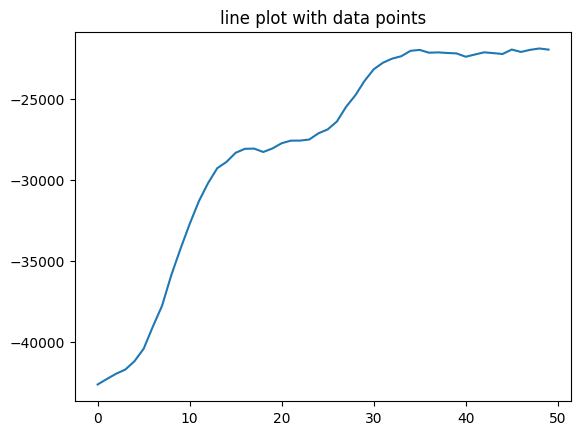

In [16]:
#Your code goes here

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(log_probabilities_gs, color='tab:blue')
ax.set_title('line plot with data points')
plt.show()


3. Use the function plot_topic_distributions to plot the sampled topic specific word ditributions $\boldsymbol{\Phi}$. Plot also the ground truth version of it. 
 * Is the $\boldsymbol{\Phi}$ sampled in the last iteration close to the ground truth? Would they get closer and closer with every iteration of the GS algorithm? Explain why.
    * No, because after burn-in state the probabilities are already trained in th LDA model.
 * The $\boldsymbol{\Phi}$ from the last GS iteration is a sample from the posterior distribution. How could we get a better estimate of the matrix $\boldsymbol{\Phi}$ still using the GS inference?
    * TODO

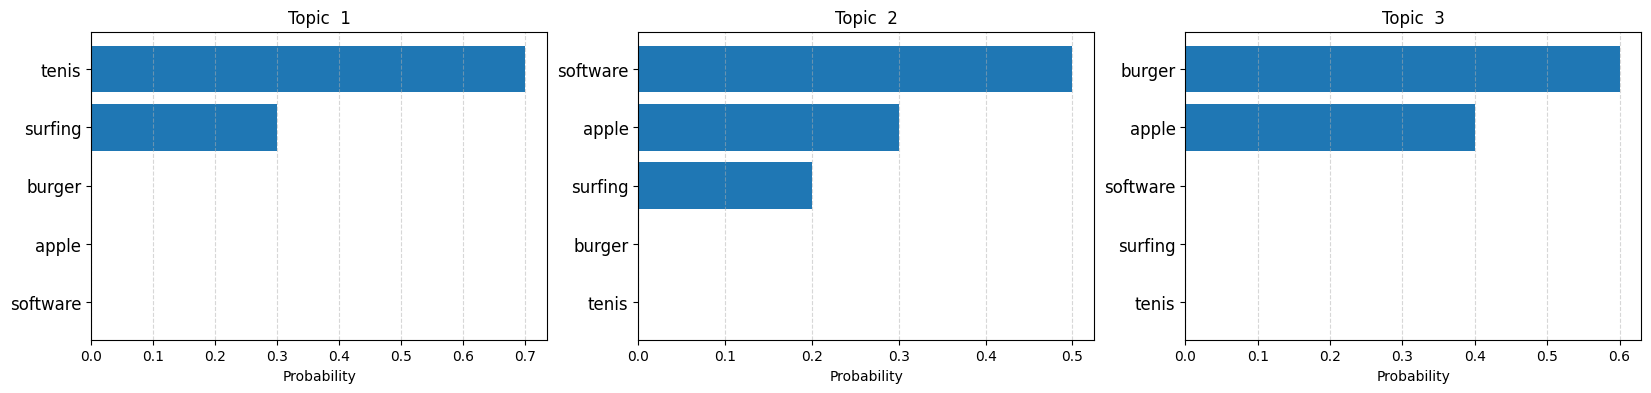

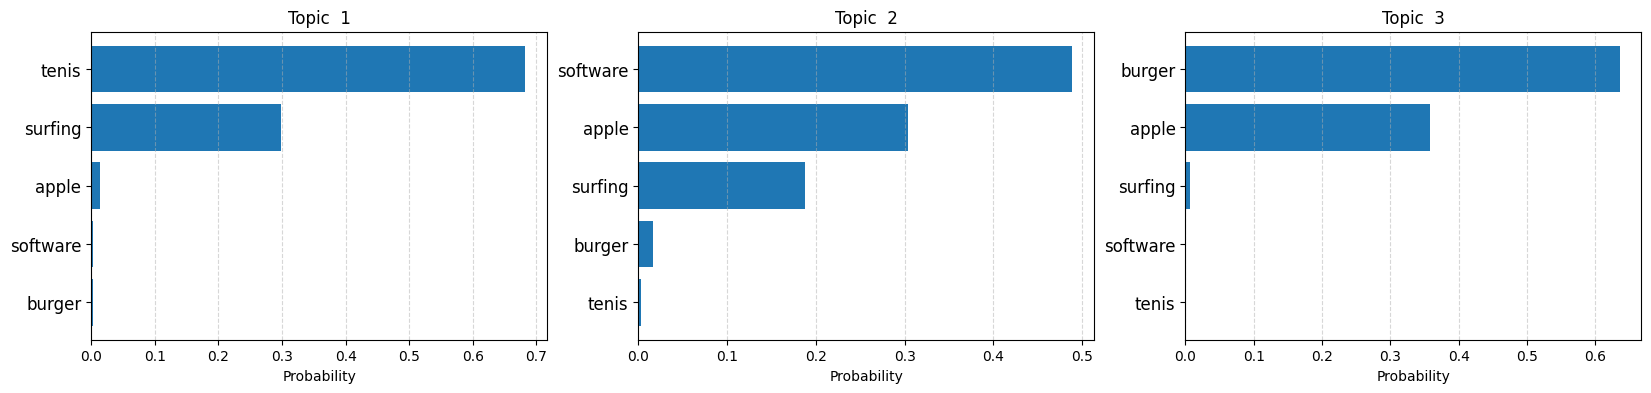

In [17]:
#Your code goes here
plot_topic_distributions(Phi_gt, vocabulary)
plot_topic_distributions(Phi_gs, vocabulary)


4. The final sampled topic mixture weights $\boldsymbol{\theta}_d$ can be seen as low dimensional representations of each document informing about their topic. Cluster the trainigg documents into 4 clusters, where each of the clusters should ideally correspond to one of the ground truth document collections. 
 * You can use for example sklearn.cluster.Agglomerative for such task.
 * Plot the documents into the simplex, as done in the section "Plotting all training ${\boldsymbol\theta}_d$ into a single simplex". For each document, indicate the label assigned by the clustering by the marker and the ground truth collection label by the color.
 * Label the corners of the simplex with the most likely word from the corresponding learned topic specific distribution $\boldsymbol{\varphi}_k$, as done in the mentioned reference plot. 
 * Comment on how well do the obtained clusters match the ground truth collection labels.
    * All fits pretty well, but software doesn't.
 * Here we are (again) rather cheating because we know the ground truth number of clusters/collections. How would you choose the number of clusters if you didn't know it?


In [18]:
!pip install scikit-learn

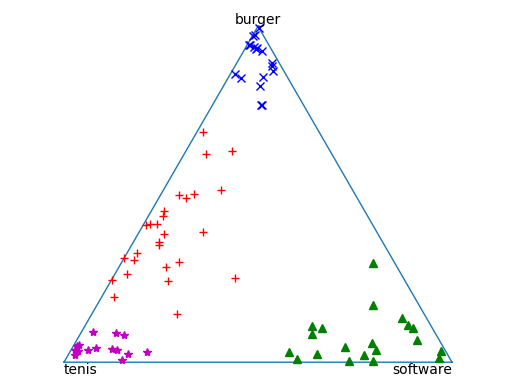

In [19]:
# Your code for clustering
from sklearn.cluster import AgglomerativeClustering

sc = AgglomerativeClustering(n_clusters=4).fit(X=Theta_gs)
plot_simplex([vocabulary[np.argmax(p)] for p in Phi_gs])
for i, t in enumerate(Theta_gs):
    plot_points_in_simplex(t,
                           c=colors[sc.labels_[i]],
                           ls=':',
                           marker=markers[sc.labels_[i]]
                           )


5. We now consider the case where we use the trained LDA model to extract topic mixture weight ${\boldsymbol\theta}_d$ representations for some additional "test" utterances. For this purpose we fix the $\boldsymbol{\Phi}$ obtained from the last GS iteration and we will only iteratively re-estimate the $\boldsymbol{\theta}_d$ and topic assignment counts $\boldsymbol{C}_{dv}^k$ for each additional test document.

 In the code below we handcraft the word count matrix **M_test** for 4 additional documents.

 * For each document in **M_test** run 50 GS iterations and store $\boldsymbol{\theta}_d$ from each iteration. 
   * Start the GS iterations from the initial values of $\boldsymbol{\theta}_d$ defined by the matrix Theta_test in the code below
   * You can try different number of iterations to get a better intuition of what is going on
 * For each document, produce a simplex plot with the points that show the evolution of $\boldsymbol{\theta}_d$ over the GS iterations.
  * Label the corners of the simplex with the most likely word from the corresponding learned topic specific distribution $\boldsymbol{\varphi}_k$. 
   * Use a single call of the function plot_points_in_simplex to plot all the $\boldsymbol{\theta}_d$ (from all iterations for a single document) at once. 
   * Connect the points from consecutive GS iterations by a dotted line (replace the parameter *ls='none'* with *ls=':'* when calling the function **plot_points_in_simplex**)
 * What topics are likely to be contained in each document? Which document collection do they seem to be coming from?
 * Look at the evolution of $\boldsymbol{\theta}_d$, can you see the burn-in phase? Where? 
 * The points for some documents should be more concentrated than for others. Explain why.

In [20]:

M_test = np.array([[6, 3, 1, 0, 0],
                   [16, 171, 110, 50, 160],
                   [6, 1, 0, 8, 5],
                   [159, 78, 14, 97, 121]])
print("Word count matrix for additional test documents\n", M_test)

#
D_test = len(M_test)
Theta_test = np.array([[1, 0, 0]] * D_test)


Word count matrix for additional test documents
 [[  6   3   1   0   0]
 [ 16 171 110  50 160]
 [  6   1   0   8   5]
 [159  78  14  97 121]]


100%|██████████| 50/50 [00:00<00:00, 1060.10it/s]


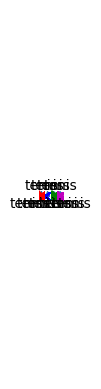

100%|██████████| 500/500 [00:00<00:00, 1286.41it/s]


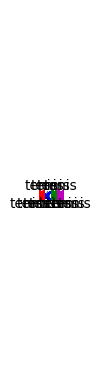

In [25]:

def plot_gs_evolution(iters=50):
    alpha_gs2, beta_gs2, Theta_gs2, Thetas_gs2, Phi_gs2, C_gs2, log_probabilities_gs2 = train_lda_GS(
        num_iterations=iters,
        D_gs=D_test,
        M_gs=M_test,
        Theta_gs=Theta_test)

    for k, v in Thetas_gs2.items():
        plt.subplot(1, Thetas_gs.__len__(), k + 1)
        plot_simplex([vocabulary[np.argmax(p)] for p in Phi])
        plot_points_in_simplex(v, ls=':', marker='x', color=colors[k])
    plt.show()


plot_gs_evolution(iters=50)
plot_gs_evolution(iters=500)


# Training LDA model using Variational Bayes inference
## Summary of the inference algorithm

The VB inference attempts to obtain a good approximation of the posterior distribution 

$$q(\boldsymbol{Z}, \boldsymbol{\Theta}, \boldsymbol{\Phi}) \approx P(\boldsymbol{Z}, \boldsymbol{\Theta}, \boldsymbol{\Phi}| \boldsymbol{W})$$

for that, we use mean field approximation, where we assume the factorization

$$q(\boldsymbol{Z}, \boldsymbol{\Theta}, \boldsymbol{\Phi}) =  q(\boldsymbol{Z}) q(\boldsymbol{\Theta}, \boldsymbol{\Phi})$$
which, because of induced factorizations, further equals to 
$$q(\boldsymbol{Z}) q(\boldsymbol{\Theta}, \boldsymbol{\Phi}) = \prod_{d=1}^D \prod_{n=1}^N q(z_{dn}) \prod_{d=1}^D q(\boldsymbol{\theta}_d) \prod_{k=1}^K q(\boldsymbol{\varphi}_k)$$

therefore we will be interested in estimating the independent approximate posterior distributions $q(\boldsymbol{\theta}_d)$ and $q(\boldsymbol{\varphi}_k)$ for each document $d$ and topic $k$. The Variational Bayes updates dictates that these distributions are $Dir(\boldsymbol{\theta}_d|\alpha_d^*)$ and $Dir(\boldsymbol{\varphi}_k|\beta_k^*)$. Our main task in the VB inference is to estimate the parameters $\alpha_d^*=[\alpha_{d1}^*,\alpha_{d2}^*,\dots,\alpha_{dK}^*]^T$ and $\beta_k^*=[\beta_{k1}^*,\beta_{k2}^*,\dots,\beta_{kV}^*]$.

The iterative algorithm for the VB inference goes as follows:

1. Initialize all $\alpha_{dk}^*$ and $\beta_{kv}^*$ (e.g. randomly).
2. For each $d=1, \dots, D$, $v=1, \dots, V$  and $k=1, \dots, K$,
$$\begin{align}
\ln \rho_{dvk} &= \psi(\alpha_{dk}^*) - \psi\left(\sum_{k'=1}^K \alpha_{dk'}^*\right) + \psi(\beta_{kv}^*) -\ \psi\left(\sum_{v=1}^V \beta_{kv}^*\right) \\
\pi_{dvk} &= \frac{\rho_{dvk}}{\sum_{k'=1}^K\rho_{dvk'}} \\
\bar{C}_{dv}^k &=\pi_{dvk} M_{dv} \\
\end{align}$$
3. For each $d=1, \dots, D$ and $k=1, \dots, K$,
$$\alpha_{dk}^* = \alpha_{0k} + \sum_{v=1}^V \bar{C}_{dv}^k$$
where  $\alpha_{0k}$ are the elements of the prior $\boldsymbol{\alpha}_0$
4. For each $k=1, \dots, K$ and $v=1, \dots, V$,
$$\beta_{kv}^* = \beta_{0v} + \sum_{d=1}^D \bar{C}_{dv}^k$$
where  $\beta_{0v}$ are the elements of the prior $\boldsymbol{\beta}_0$
5. Go to step 2. and repeat for a desired number of iterations 

To monitor progress, we can evaluate $\mathcal{L}(q(\boldsymbol{Z}, \boldsymbol{\Theta}, \boldsymbol{\Phi}))$ in every iteration. It is easiest done right after the step 2. as described on slide 31. "Efficient ELBO calculation" in the [BAYa class slides](http://www.fit.vutbr.cz/study/courses/BAYa/public/prednasky/4.5-LatentDirichletAllocation.pdf)).

After the convergence, we can represent each document by the **expected** vector of topic mixture weights (i.e. expected value of variable $\boldsymbol{\theta}_d$)

$$\boldsymbol{\hat{\theta}}_d = \mathbb{E}_{q(\boldsymbol{\theta}_d)}[\boldsymbol{\theta}_d)] = \int \boldsymbol{\theta}_d \operatorname{Dir}(\boldsymbol{\theta}_d|\boldsymbol{\alpha}_d^*) d\boldsymbol{\theta}_d = \frac{\boldsymbol{\alpha}_d^*}{\sum_{k=1}^K \alpha_{dk}^*},$$
which can be seen as the posterior predictive distribution over topics for document $d$. Similarly, we can obtain expected topic specific word distributions
$$\boldsymbol{\hat{\varphi}}_k = \mathbb{E}_{q(\boldsymbol{\varphi}_k)}[\boldsymbol{\varphi}_k)] = \frac{\boldsymbol{\beta}_k^*}{\sum_{v=1}^V \beta_{kv}^*},$$





$$
\sum_{d=1}^{D}\sum_{v=1}^{V}\sum_{k=1}^{K} [C_{d,v}^{k} \times (ln(\rho_{dvk})-ln(\pi_{dvk}))]
$$


## Tasks and questions:

1. Implement Variational Bayes inference for training the Bayesian Latent Dirichlet Allocation model described above. 
 * Run sufficient number of VB iterations to make the algorithm converge
 * Store the ELBO $\mathcal{L}(q(\boldsymbol{Z}, \boldsymbol{\Theta}, \boldsymbol{\Phi}))$ in every iteration to monitor the convergence.

 The following field comes with the definition of variables that you will use in your implementation. As done before for the Gibbs Sampling inference, we provide parameters of priors **alpha0** and **beta0**.
The rows of the matrix **alpha** the initial parameters for individual approximate posteriors $q(\boldsymbol{\theta}_d)$ for all documents $d$. Similarly, each of the rows of **beta** are the initial parameters for each $q(\boldsymbol{\varphi}_k)$.
Please reuse the variables **alpha** and **beta** to store the parameters updated in each VB iteration. As before we choose $K=3$.

In [26]:
# Make use of the following variables

D, V = M.shape  # number of training documents D and size of vocabulary V
K = 3
alpha0 = np.ones(K, dtype='float')  # Parameters of prior for Theta
beta0 = np.ones(V, dtype='float')  # Parameters of prior for Phi
alpha = np.random.randn(D, K)  # rows are initial parameters of approximate posterior for each q(theta_d)
beta = np.random.randn(K, V)  # rows are initial parameters of approximate posterior for each q(varphi_k)
# Reuse the variables alpha and beta to store the parameters of the approximate posteriors updated in each VB iteration

In [27]:

print(alpha0)
print(beta0)
print(alpha)
print(beta)


[1. 1. 1.]
[1. 1. 1. 1. 1.]
[[ 0.53350115  1.1007091  -0.68235986]
 [ 0.65014289  0.00910708 -0.98332304]
 [-0.21977714 -1.58993113 -0.71734579]
 [ 0.21468344  0.51563823 -0.30073516]
 [-1.4096298   0.19175805  0.01728343]
 [-0.16266006  0.41364337 -0.10927012]
 [ 0.18819507 -0.70174804 -0.1103871 ]
 [-0.07933843  1.34053835  0.520685  ]
 [ 0.3029491  -0.54611997  0.2159223 ]
 [-1.64918486 -0.25286102 -1.07051795]
 [-1.89957432  0.91776698  0.65954164]
 [-2.19607053 -0.54636008 -0.21957407]
 [-0.56257705 -0.05024713  1.57216022]
 [ 2.32097302  0.81049147 -0.53047614]
 [ 0.59603815  0.01072269 -0.32722411]
 [-0.73610886 -0.98652807 -0.8339525 ]
 [ 1.02302645  0.68330604 -0.57356106]
 [ 1.5893382  -0.62211858 -0.06536455]
 [ 1.56880487 -0.52095408 -1.04647486]
 [-0.76853306  0.107972   -0.86922915]
 [-1.39595977 -1.72076123  0.30223193]
 [ 1.40795036  0.1993195   0.48241257]
 [ 1.36978321 -0.18056959  0.96934873]
 [-0.0621179  -1.49459547 -0.44309262]
 [ 0.40877606  0.90652561  0.0329017

In [28]:
# Your code for Variational Bayes inference

from scipy.special import loggamma, digamma


def Dirichlet_KL(alpha1, alpha2):
    """Source: https://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks/vb_gmm_training.ipynb"""
    # Calculates KL(p1||p2) for two Dirichlet distributions
    return (loggamma(np.sum(alpha1)) - np.sum(loggamma(alpha1))
            - loggamma(np.sum(alpha2)) + np.sum(loggamma(alpha2))
            + np.sum((alpha1 - alpha2) * (digamma(alpha1) - digamma(np.sum(alpha1)))))


def train_lda_VB(num_iterations: int = 1,
                 D_vb=D,
                 V_vb=V,
                 K_vb=K,
                 M_vb=M.copy(),
                 Phi_vb=Phi.copy(),
                 Theta_vb=Theta.copy(),
                 alpha_vb=alpha.copy(),
                 beta_vb=beta.copy()):
    C = np.zeros((D_vb, V_vb, K_vb))
    elbo = []

    #
    for _ in tqdm.tqdm(range(num_iterations)):
        a = digamma(alpha_vb) - digamma(np.sum(alpha_vb, axis=-1))[:, None]
        b = digamma(beta_vb) - digamma(np.sum(beta_vb, axis=-1))[:, None]
        rho = np.swapaxes(np.exp(a[:, :, None] + b), 1, -1)
        pi = rho / np.sum(rho, axis=-1, keepdims=True)
        C = pi * M_vb[:, :, None]

        # # 3.
        alpha_vb = alpha0 + np.sum(C, axis=V_idx)

        # 4.
        beta_vb = beta0 + np.swapaxes(np.sum(C, axis=D_idx), D_idx, V_idx)

        # 5.
        kl_a = 0
        for a in alpha_vb:
            kl_a += Dirichlet_KL(a, alpha0)
        kl_b = 0
        for b in beta_vb:
            kl_b += Dirichlet_KL(b, beta0)
        C_rho = np.sum(np.sum(C, axis=2) * np.log(np.sum(rho, axis=2)))
        elbo.append(C_rho - kl_a - kl_b)
    return alpha_vb, beta_vb, C, elbo


alpha_vb, beta_vb, C_vb, elbo = train_lda_VB(num_iterations=100)

#
Theta_vb = alpha_vb / np.sum(alpha_vb, axis=-1, keepdims=True)
Phi_vb = beta_vb / np.sum(beta_vb, axis=-1, keepdims=True)



  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/9c/z5w432ls60300pg8dcrpkhkr0000gn/T/ipykernel_21557/3641667730.py:30: RuntimeWarning: overflow encountered in exp
  rho = np.swapaxes(np.exp(a[:, :, None] + b), 1, -1)
/var/folders/9c/z5w432ls60300pg8dcrpkhkr0000gn/T/ipykernel_21557/3641667730.py:31: RuntimeWarning: invalid value encountered in divide
  pi = rho / np.sum(rho, axis=-1, keepdims=True)
100%|██████████| 100/100 [00:00<00:00, 315.84it/s]


In [29]:
elbo = elbo[1:]


2. Plot the evolution of ELBO $\mathcal{L}(q(\boldsymbol{Z}, \boldsymbol{\Theta}, \boldsymbol{\Phi}))$  over the iterations to monitor the convergence of the VB inference. 
 * What can we see from the plot? In how many iterations does the VB inference converge?
 * How does it differ from $\ln P(\boldsymbol{W}, \boldsymbol{Z}, \boldsymbol{\Theta}, \boldsymbol{\Phi})$ that we ploted for the Gibbs Sampling inference?

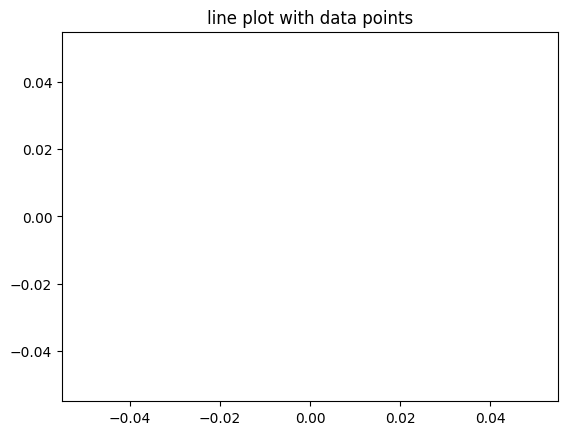

In [30]:
#Your code goes here

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(elbo, color='tab:blue')
ax.set_title('line plot with data points')
plt.show()


3. Use the function plot_topic_distributions to plot the 
expected topic specific word ditributions $\boldsymbol{\hat{\Phi}} = [\boldsymbol{\hat{\varphi}}_1, \boldsymbol{\hat{\varphi}}_2, \dots, \boldsymbol{\hat{\varphi}}_K]$. Plot also the ground truth $\boldsymbol{\Phi}$. Is the learned $\boldsymbol{\hat{\Phi}}$ close to the ground truth?


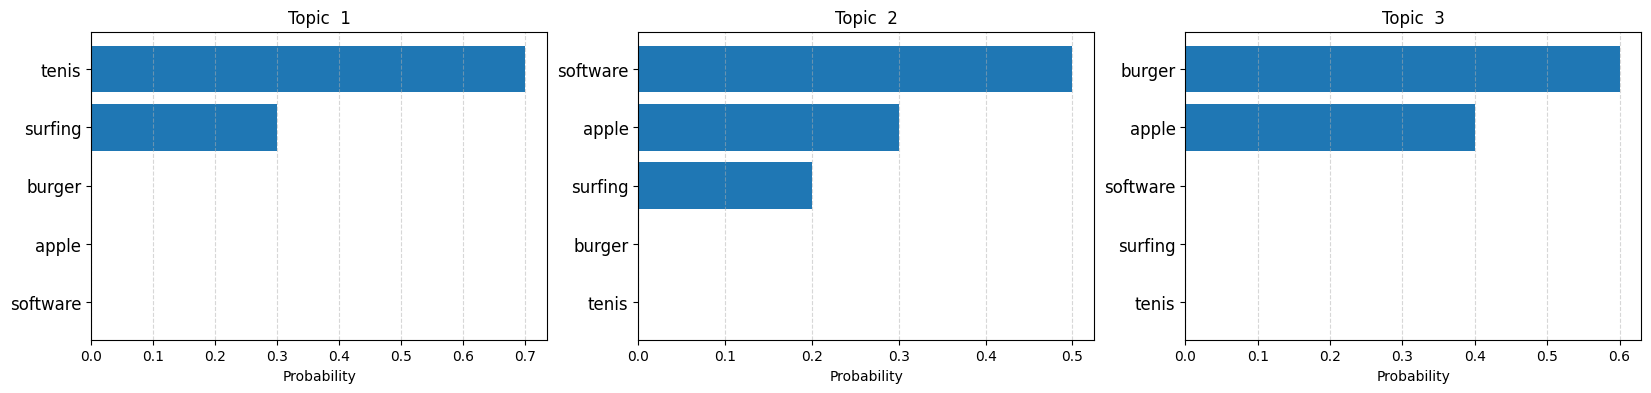

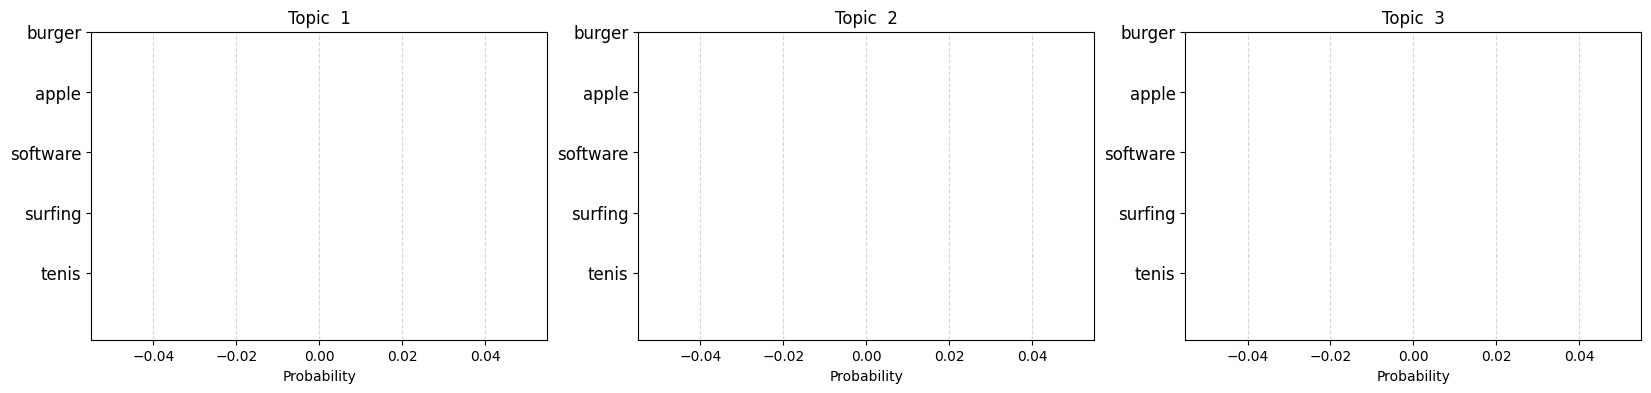

In [31]:
#Your code goes here

plot_topic_distributions(Phi_gt, vocabulary)
plot_topic_distributions(Phi_vb, vocabulary)



4. Evaluate expected topic mixture weights $\boldsymbol{\hat{\theta}}_d$ for each training document $d$ and cluster them into 4 clusters in a similar way as we did for the GS inference.
 * As for GS inference, plot all $\boldsymbol{\hat{\theta}}_d$ into one simplex. For each document, indicate the label assigned by the clustering by the marker and the ground truth collection label by the color.
 * Again, label the corners of the simplex with the most likely word from the corresponding learned expected topic specific distribution $\boldsymbol{\hat{\varphi}}_k$. 
 * Comment on how well do the obtained clusters match the ground truth collection labels.
 * Is there any difference compared to the clustering obtained in the GS inference case?

In [32]:
#Your code for clustering

sc = AgglomerativeClustering(n_clusters=4).fit(X=Theta_vb)
plot_simplex([vocabulary[np.argmax(p)] for p in Phi_vb])
for i, t in enumerate(Theta_gs):
    plot_points_in_simplex(t,
                           c=colors[sc.labels_[i]],
                           ls=':',
                           marker=markers[sc.labels_[i]]
                           )


ValueError: Input X contains NaN.
AgglomerativeClustering does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

5. As we did before for the GS inference, consider now the case where we use the LDA model trained using VB inference to extract expected topic mixture weight $\boldsymbol{\hat{\theta}}_d$ for the 4 additional utterances represented by the matrix **M_test** (as defined before). For this purpose, run VB inference where all $\boldsymbol{\beta}_k^*$ (and therefore also $q(\boldsymbol{\varphi}_k$) stay fixed.
 * For each of the 4 documents, produce separate 2-simplex plot using function **plot_simplex**
  * Label the corners of each simplex with the most likely word from the corresponding expected topic specific distribution $\boldsymbol{\hat{\varphi}}_k$. 
 * To each simplex, plot document specific dirichlet distribution $q(\boldsymbol{{\theta}}_d)$ using the fuction  **plot_dirichlet**.
 * What dose this plot represent? How does it differ for the different test documents and why?
 * To each simplex, plot the corresponding expected topic mixture weights $\boldsymbol{\hat{\theta}}_d$ as a single point using the function **plot_points_in_simplex**.

100%|██████████| 50/50 [00:00<00:00, 2844.64it/s]

0
1
2
3


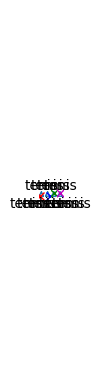

100%|██████████| 500/500 [00:00<00:00, 2462.16it/s]


0
1
2
3


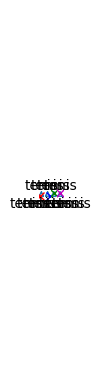

In [46]:
#Your code goes here

M_test = np.array([[6, 3, 1, 0, 0],
                   [16, 171, 110, 50, 160],
                   [6, 1, 0, 8, 5],
                   [159, 78, 14, 97, 121]])
D_test = len(M_test)
Alpha_test = np.abs(np.random.randn(D_test, K))


def plot_vb_evolution(iters=50):
    alpha_vb2, beta_vb2, C_vb2, elbo2 = train_lda_VB(num_iterations=iters,
                                                     alpha_vb=Alpha_test,
                                                     D_vb=D_test,
                                                     M_vb=M_test)
    Theta_vb2 = alpha_vb2 / np.sum(alpha_vb2, axis=-1, keepdims=True)

    for k, v in enumerate(Theta_vb2):
        print(k)
        plt.subplot(1, Theta_vb.__len__(), k + 1)
        plot_simplex([vocabulary[np.argmax(p)] for p in Phi])
        plot_points_in_simplex(v, ls=':', marker='x', color=colors[k])
    plt.show()


plot_vb_evolution(iters=50)
plot_vb_evolution(iters=500)
